In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
noise_type = 'gaussian'      # 'gaussian', 'saltpepper', 'speckle'
model_type = 'conv'          # Options: 'fc', 'conv'
epochs = 10
batch = 128
latent_dim = 64

In [3]:
(train_x, _), (test_x, _) = tf.keras.datasets.mnist.load_data()
train_x = train_x.astype('float32') / 255.
test_x = test_x.astype('float32') / 255.
train_x = np.reshape(train_x, (-1, 28, 28, 1))
test_x = np.reshape(test_x, (-1, 28, 28, 1))


A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 731c5ac602752760c8e48fbffcf8c3b850d9dc2a2aedcf2cc48468fc17b673d1 so we will re-download the data.
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [4]:
def add_gaussian_noise(imgs, amount=0.5):
    noise = amount * np.random.normal(loc=0.0, scale=1.0, size=imgs.shape)
    return np.clip(imgs + noise, 0., 1.)

In [5]:
def add_saltpepper_noise(imgs, amount=0.2):
    out = np.copy(imgs)
    num_salt = np.ceil(amount * imgs.size * 0.5)
    coords = [np.random.randint(0, i-1, int(num_salt)) for i in imgs.shape]
    out[tuple(coords)] = 1
    num_pepper = np.ceil(amount* imgs.size * 0.5)
    coords = [np.random.randint(0, i-1, int(num_pepper)) for i in imgs.shape]
    out[tuple(coords)] = 0
    return out

In [6]:

def add_speckle_noise(imgs, amount=0.5):
    noise = amount * np.random.randn(*imgs.shape)
    return np.clip(imgs + imgs * noise, 0., 1.)

In [7]:
if noise_type == 'gaussian':
    noisy_train = add_gaussian_noise(train_x)
    noisy_test = add_gaussian_noise(test_x)
elif noise_type == 'saltpepper':
    noisy_train = add_saltpepper_noise(train_x)
    noisy_test = add_saltpepper_noise(test_x)
elif noise_type == 'speckle':
    noisy_train = add_speckle_noise(train_x)
    noisy_test = add_speckle_noise(test_x)
else:
    noisy_train = train_x
    noisy_test = test_x

In [11]:
# Encoder
inputs = tf.keras.Input(shape=(28,28,1))
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
x = tf.keras.layers.MaxPooling2D((2,2), padding='same')(x)
x = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2,2), padding='same')(x)
encoded = tf.keras.layers.Conv2D(8, (3,3), activation='relu', padding='same')(x)

# Decoder (FIXED: 'padding=same' added to all Conv2D layers below)
x = tf.keras.layers.UpSampling2D((2,2))(encoded)
x = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)  # FIXED
x = tf.keras.layers.UpSampling2D((2,2))(x)
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)  # FIXED
outputs = tf.keras.layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)  # FIXED

autoencoder = tf.keras.Model(inputs, outputs)

In [12]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [13]:
history = autoencoder.fit(
    noisy_train, train_x,
    epochs=epochs,
    batch_size=batch,
    shuffle=True,
    validation_data=(noisy_test, test_x)
)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 49s 89ms/step - loss: 0.1799 - val_loss: 0.1229
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - loss: 0.1182 - val_loss: 0.1131
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 73s 70ms/step - loss: 0.1123 - val_loss: 0.1095
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - loss: 0.1091 - val_loss: 0.1081
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - loss: 0.1071 - val_loss: 0.1051
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - loss: 0.1056 - val_loss: 0.1039
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - loss: 0.1044 - val_loss: 0.1030
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 82ms/step - loss: 0.1035 - val_loss: 0.1023
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 84ms/step - loss: 0.1028 - val_loss: 0.1015
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 80ms/step - loss: 0.1020 - val_loss: 0.1010


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


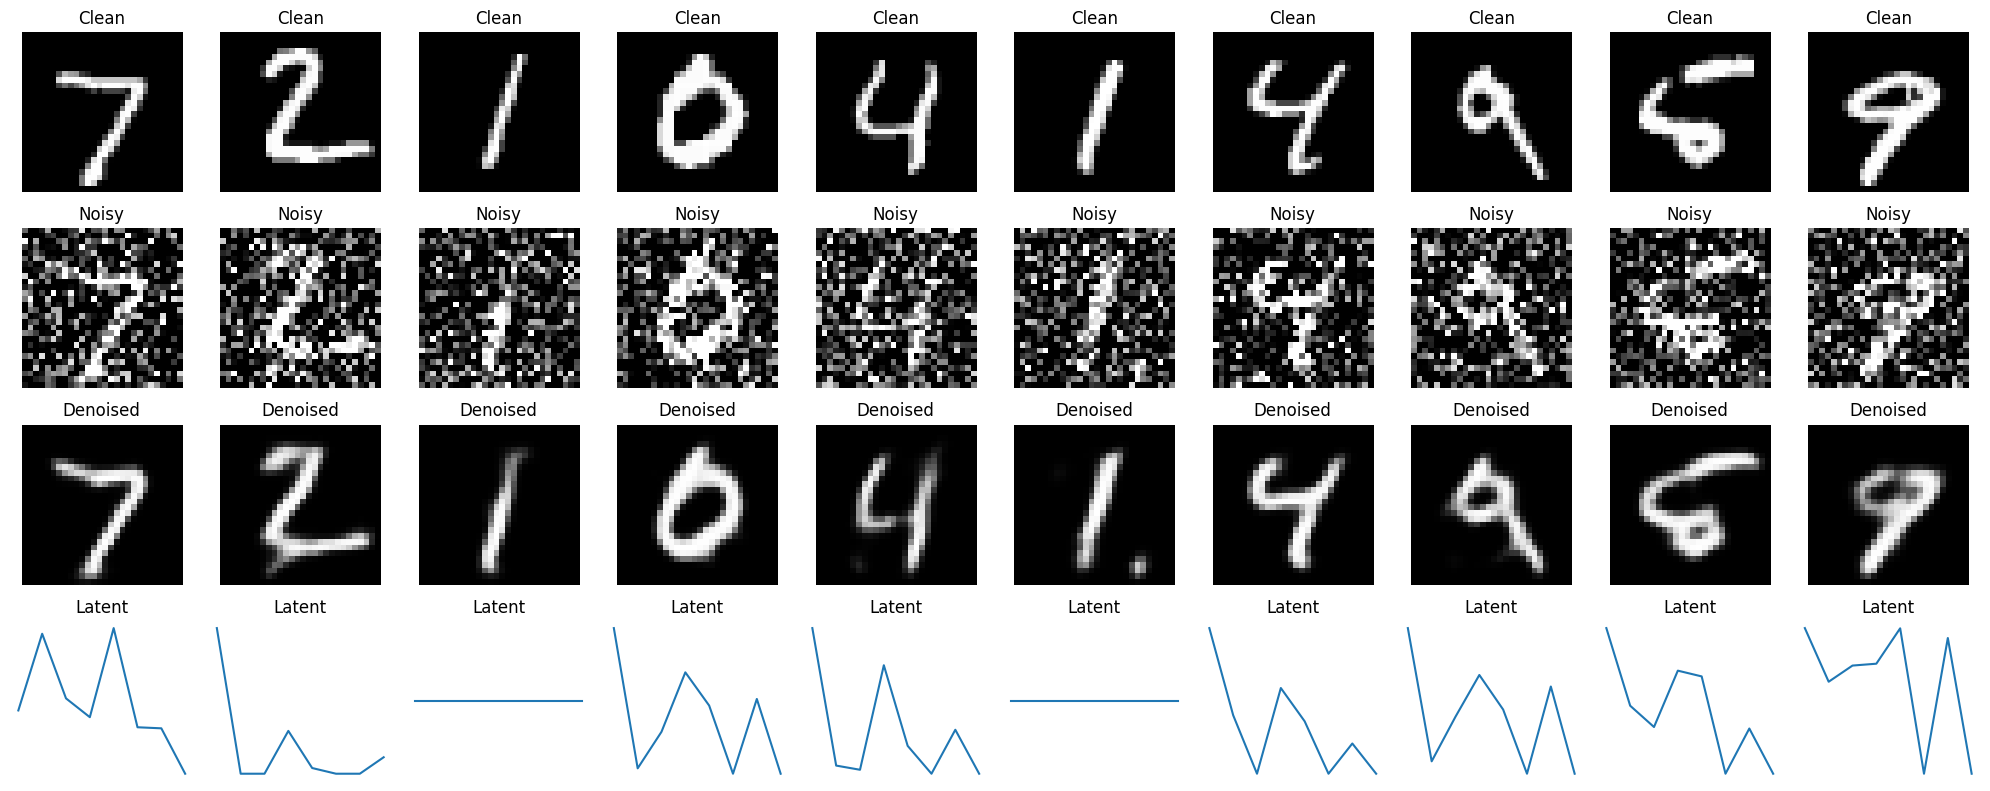

In [14]:
decoded_imgs = autoencoder.predict(noisy_test[:10])

plt.figure(figsize=(20, 8))
for i in range(10):
    a = plt.subplot(4, 10, i + 1)
    plt.imshow(test_x[i].reshape(28,28), cmap='gray')
    plt.title("Clean")
    plt.axis('off')
    
    b = plt.subplot(4, 10, i + 11)
    plt.imshow(noisy_test[i].reshape(28,28), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')
    
    c = plt.subplot(4, 10, i + 21)
    plt.imshow(decoded_imgs[i].reshape(28,28), cmap='gray')
    plt.title("Denoised")
    plt.axis('off')
    
    # Visualize latent space (reshape if possible)
    d = plt.subplot(4, 10, i + 31)
    lat = encoder.predict(test_x[i:i+1])
    lat_img = lat.reshape(-1, lat.shape[-1]) if model_type == 'fc' else lat.reshape(-1, lat.shape[-1])
    plt.plot(lat_img[0])
    plt.title('Latent')
    plt.axis('off')
plt.tight_layout()
plt.show()

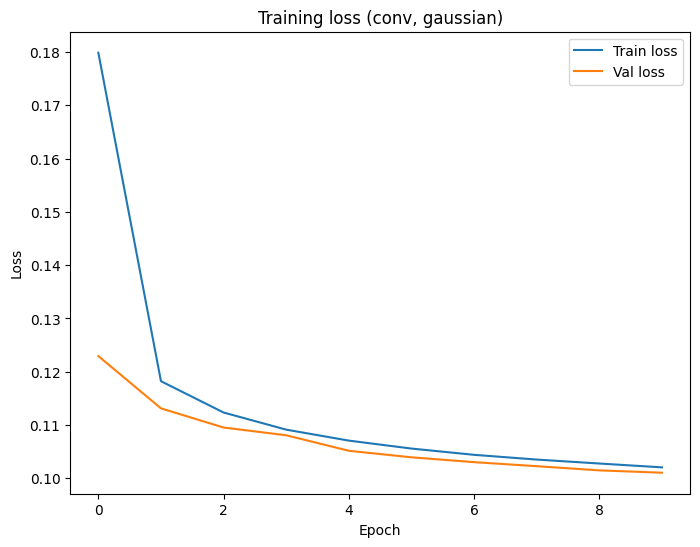

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title(f"Training loss ({model_type}, {noise_type})")
plt.show()